# Section: Federated Learning

# Lesson: Introducing Federated Learning

Federated Learning is a technique for training Deep Learning models on data to which you do not have access. Basically:

Federated Learning: Instead of bringing all the data to one machine and training a model, we bring the model to the data, train it locally, and merely upload "model updates" to a central server.

Use Cases:

    - app company (Texting prediction app)
    - predictive maintenance (automobiles / industrial engines)
    - wearable medical devices
    - ad blockers / autotomplete in browsers (Firefox/Brave)
    
Challenge Description: data is distributed amongst sources but we cannot aggregated it because of:

    - privacy concerns: legal, user discomfort, competitive dynamics
    - engineering: the bandwidth/storage requirements of aggregating the larger dataset

# Lesson: Introducing / Installing PySyft

In order to perform Federated Learning, we need to be able to use Deep Learning techniques on remote machines. This will require a new set of tools. Specifically, we will use an extensin of PyTorch called PySyft.

### Install PySyft

The easiest way to install the required libraries is with [Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/overview.html). Create a new environment, then install the dependencies in that environment. In your terminal:

```bash
conda create -n pysyft python=3
conda activate pysyft # some older version of conda require "source activate pysyft" instead.
conda install jupyter notebook
pip install syft
pip install numpy
```

If you have any errors relating to zstd - run the following (if everything above installed fine then skip this step):

```
pip install --upgrade --force-reinstall zstd
```

and then retry installing syft (pip install syft).

If you are using Windows, I suggest installing [Anaconda and using the Anaconda Prompt](https://docs.anaconda.com/anaconda/user-guide/getting-started/) to work from the command line. 

With this environment activated and in the repo directory, launch Jupyter Notebook:

```bash
jupyter notebook
```

and re-open this notebook on the new Jupyter server.

If any part of this doesn't work for you (or any of the tests fail) - first check the [README](https://github.com/OpenMined/PySyft.git) for installation help and then open a Github Issue or ping the #beginner channel in our slack! [slack.openmined.org](http://slack.openmined.org/)

In [1]:
import torch as th

In [2]:
x = th.tensor([1,2,3,4,5])
x

tensor([1, 2, 3, 4, 5])

In [3]:
y = x + x

In [4]:
print(y)

tensor([ 2,  4,  6,  8, 10])


In [5]:
import syft as sy

In [6]:
hook = sy.TorchHook(th)

In [7]:
th.tensor([1,2,3,4,5])

tensor([1, 2, 3, 4, 5])

# Lesson: Basic Remote Execution in PySyft

## PySyft => Remote PyTorch

The essence of Federated Learning is the ability to train models in parallel on a wide number of machines. Thus, we need the ability to tell remote machines to execute the operations required for Deep Learning.

Thus, instead of using Torch tensors - we're now going to work with **pointers** to tensors. Let me show you what I mean. First, let's create a "pretend" machine owned by a "pretend" person - we'll call him Bob.

In [8]:
bob = sy.VirtualWorker(hook, id="bob")

In [9]:
bob._objects

{}

In [10]:
x = th.tensor([1,2,3,4,5])

In [11]:
x = x.send(bob)

In [12]:
bob._objects

{31305363757: tensor([1, 2, 3, 4, 5])}

In [13]:
x.location

<VirtualWorker id:bob #tensors:1>

In [14]:
x.id_at_location

31305363757

In [15]:
x.id

25007010136

In [16]:
x.owner

<VirtualWorker id:me #tensors:0>

In [17]:
hook.local_worker

<VirtualWorker id:me #tensors:0>

In [18]:
x

(Wrapper)>[PointerTensor | me:25007010136 -> bob:31305363757]

In [19]:
x = x.get()
x

tensor([1, 2, 3, 4, 5])

In [20]:
bob._objects

{}

# Project: Playing with Remote Tensors

In this project, I want you to .send() and .get() a tensor to TWO workers by calling .send(bob,alice). This will first require the creation of another VirtualWorker called alice.

In [21]:
# try this project here!

In [22]:
alice = sy.VirtualWorker(hook, id='alice')
bob = sy.VirtualWorker(hook, id='bob')
x = th.tensor([1,2,3,4,5])

In [23]:
x = x.send(alice, bob)

In [24]:
x.id

48279269661

In [25]:
x.location

In [26]:
alice._objects

{35229948617: tensor([1, 2, 3, 4, 5])}

In [27]:
bob._objects

{40261066972: tensor([1, 2, 3, 4, 5])}

In [28]:
x

(Wrapper)>[MultiPointerTensor]
	-> (Wrapper)>[PointerTensor | me:74162098053 -> alice:35229948617]
	-> (Wrapper)>[PointerTensor | me:51171904327 -> bob:40261066972]

In [29]:
x = x.get()

In [30]:
x

[tensor([1, 2, 3, 4, 5]), tensor([1, 2, 3, 4, 5])]

In [32]:
x = th.tensor([1,2,3,4,5])
x = x.send(alice, bob)
x

(Wrapper)>[MultiPointerTensor]
	-> (Wrapper)>[PointerTensor | me:13745025796 -> alice:28608362191]
	-> (Wrapper)>[PointerTensor | me:34579059350 -> bob:45107623585]

In [33]:
x.get(sum_results=True)

tensor([ 2,  4,  6,  8, 10])

# Lesson: Introducing Remote Arithmetic

In [34]:
x = th.tensor([1,2,3,4,5]).send(bob)
y = th.tensor([1,1,1,1,1]).send(bob)

In [35]:
x

(Wrapper)>[PointerTensor | me:41139469901 -> bob:50914230187]

In [36]:
y

(Wrapper)>[PointerTensor | me:5261968099 -> bob:62400964991]

In [37]:
z = x + y

In [38]:
z

(Wrapper)>[PointerTensor | me:8890845018 -> bob:11843018997]

In [39]:
z = z.get()
z

tensor([2, 3, 4, 5, 6])

In [40]:
z = th.add(x,y)
z

(Wrapper)>[PointerTensor | me:60643991885 -> bob:22655793740]

In [41]:
z = z.get()
z

tensor([2, 3, 4, 5, 6])

In [42]:
x = th.tensor([1.,2,3,4,5], requires_grad=True).send(bob)
y = th.tensor([1.,1,1,1,1], requires_grad=True).send(bob)

In [43]:
z = (x + y).sum()

In [44]:
z.backward()

(Wrapper)>[PointerTensor | me:12736118456 -> bob:61006598709]

In [45]:
x = x.get()

In [46]:
x

tensor([1., 2., 3., 4., 5.], requires_grad=True)

In [47]:
x.grad

tensor([1., 1., 1., 1., 1.])

# Project: Learn a Simple Linear Model

In this project, I'd like for you to create a simple linear model which will solve for the following dataset below. You should use only Variables and .backward() to do so (no optimizers or nn.Modules). Furthermore, you must do so with both the data and the model being located on Bob's machine.

In [48]:
# try this project here!

In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
bob = sy.VirtualWorker(hook, id='bob')

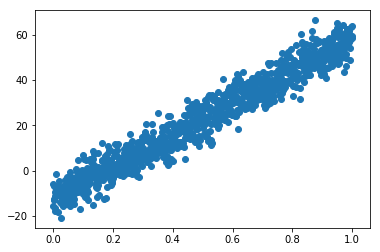

In [51]:
x = np.linspace(0, 1, 1000)
y = 70.0 * x + 5.0 * np.random.randn(x.shape[0]) - 12.0
plt.scatter(x, y)

In [52]:
# Create the tensors
x_t = th.tensor(x)
y_t = th.tensor(y)
coefs = th.tensor(np.random.randn(2), requires_grad=True)
eta = th.tensor(0.05)

# Send the tensors
x_remote = x_t.send(bob)
y_remote = y_t.send(bob)
coefs = coefs.send(bob)
eta = eta.send(bob)

In [53]:
# Operate remotely
x_big = th.cat((x_remote.view(-1, 1), th.ones_like(x_remote).view(-1, 1)), dim=1)

for i in range(1000):
    y_pred = x_big.mm(coefs.view(-1, 1))
    loss = ((y_remote.view(1, -1) - y_pred.view(1, -1)) ** 2).mean()
    loss.backward()
    
    # Gradient descent
    with th.no_grad():
        coefs -=  eta * coefs.grad
    coefs.grad.zero_()
    print(f'Iteration {i}. Loss: {loss.item()}')

Iteration 0. Loss: 1080.815733223369
Iteration 1. Loss: 900.3584444086578
Iteration 2. Loss: 761.8279748666777
Iteration 3. Loss: 655.2806420933148
Iteration 4. Loss: 573.1338010382055
Iteration 5. Loss: 509.6052013839254
Iteration 6. Loss: 460.2854733225252
Iteration 7. Loss: 421.81212953944475
Iteration 8. Loss: 391.6209776735916
Iteration 9. Loss: 367.756561596395
Iteration 10. Loss: 348.7276147053581
Iteration 11. Loss: 333.3968368156304
Iteration 12. Loss: 320.89684427216116
Iteration 13. Loss: 310.5660782689693
Iteration 14. Loss: 301.89993216036254
Iteration 15. Loss: 294.5134839086283
Iteration 16. Loss: 288.113077947912
Iteration 17. Loss: 282.47465510899707
Iteration 18. Loss: 277.4272282311636
Iteration 19. Loss: 272.8402815821449
Iteration 20. Loss: 268.6141623508805
Iteration 21. Loss: 264.6727537248119
Iteration 22. Loss: 260.95788777384894
Iteration 23. Loss: 257.42508501206885
Iteration 24. Loss: 254.04030560855702
Iteration 25. Loss: 250.77747202452522
Iteration 26. Lo

Iteration 290. Loss: 31.29637674936101
Iteration 291. Loss: 31.20723513560775
Iteration 292. Loss: 31.1192640259215
Iteration 293. Loss: 31.032448050603254
Iteration 294. Loss: 30.946772041771045
Iteration 295. Loss: 30.862221030709897
Iteration 296. Loss: 30.778780245256655
Iteration 297. Loss: 30.69643510721893
Iteration 298. Loss: 30.615171229828324
Iteration 299. Loss: 30.53497441522669
Iteration 300. Loss: 30.455830651985693
Iteration 301. Loss: 30.377726112658756
Iteration 302. Loss: 30.30064715136529
Iteration 303. Loss: 30.224580301406533
Iteration 304. Loss: 30.149512272912762
Iteration 305. Loss: 30.075429950521382
Iteration 306. Loss: 30.002320391085494
Iteration 307. Loss: 29.93017082141256
Iteration 308. Loss: 29.858968636032753
Iteration 309. Loss: 29.78870139499665
Iteration 310. Loss: 29.719356821701744
Iteration 311. Loss: 29.65092280074765
Iteration 312. Loss: 29.5833873758193
Iteration 313. Loss: 29.516738747598094
Iteration 314. Loss: 29.450965271700337
Iteration 31

Iteration 566. Loss: 24.684433651357075
Iteration 567. Loss: 24.68211238963823
Iteration 568. Loss: 24.679821608030398
Iteration 569. Loss: 24.677560906304173
Iteration 570. Loss: 24.675329889485525
Iteration 571. Loss: 24.67312816778674
Iteration 572. Loss: 24.67095535653835
Iteration 573. Loss: 24.66881107612193
Iteration 574. Loss: 24.666694951903732
Iteration 575. Loss: 24.664606614169323
Iteration 576. Loss: 24.662545698058864
Iteration 577. Loss: 24.660511843503482
Iteration 578. Loss: 24.65850469516224
Iteration 579. Loss: 24.656523902360245
Iteration 580. Loss: 24.65456911902713
Iteration 581. Loss: 24.652640003636808
Iteration 582. Loss: 24.650736219147667
Iteration 583. Loss: 24.648857432943775
Iteration 584. Loss: 24.647003316776694
Iteration 585. Loss: 24.645173546708172
Iteration 586. Loss: 24.643367803053533
Iteration 587. Loss: 24.641585770325843
Iteration 588. Loss: 24.639827137180774
Iteration 589. Loss: 24.638091596362187
Iteration 590. Loss: 24.636378844648508
Iterat

Iteration 845. Loss: 24.51207864011543
Iteration 846. Loss: 24.51202054408467
Iteration 847. Loss: 24.51196321090345
Iteration 848. Loss: 24.51190663055494
Iteration 849. Loss: 24.5118507931538
Iteration 850. Loss: 24.511795688944524
Iteration 851. Loss: 24.51174130829967
Iteration 852. Loss: 24.511687641718247
Iteration 853. Loss: 24.51163467982399
Iteration 854. Loss: 24.511582413363783
Iteration 855. Loss: 24.51153083320597
Iteration 856. Loss: 24.51147993033886
Iteration 857. Loss: 24.511429695869033
Iteration 858. Loss: 24.511380121019858
Iteration 859. Loss: 24.51133119713001
Iteration 860. Loss: 24.511282915651808
Iteration 861. Loss: 24.511235268149875
Iteration 862. Loss: 24.511188246299547
Iteration 863. Loss: 24.511141841885514
Iteration 864. Loss: 24.511096046800304
Iteration 865. Loss: 24.511050853042935
Iteration 866. Loss: 24.511006252717447
Iteration 867. Loss: 24.51096223803162
Iteration 868. Loss: 24.51091880129548
Iteration 869. Loss: 24.51087593492007
Iteration 870.

In [54]:
# Retrieve the results
coefs = coefs.get()
x_big_local = th.cat([x_t.view(-1, 1), th.ones_like(x_t).view(-1, 1)], 1)
y_pred = x_big_local.mm(coefs.view(-1, 1))
coefs

tensor([ 70.0801, -12.2301], dtype=torch.float64, requires_grad=True)

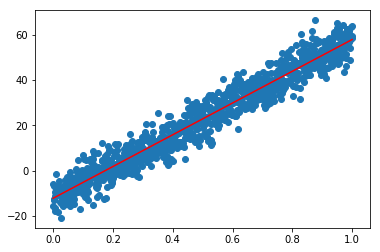

In [55]:
# Show the results
plt.scatter(x, y)
plt.plot(x, y_pred.data.numpy(), 'r')

# Lesson: Garbage Collection and Common Errors


In [56]:
alice2 = sy.VirtualWorker(hook, id='alice2')
bob2 = sy.VirtualWorker(hook, id='bob2')

In [57]:
bob2.clear_objects()

<VirtualWorker id:bob2 #tensors:0>

In [58]:
bob2._objects

{}

In [59]:
x = th.tensor([1,2,3,4,5]).send(bob2)

In [60]:
bob2._objects

{82158858750: tensor([1, 2, 3, 4, 5])}

In [61]:
del x

In [63]:
bob2._objects

{}

In [64]:
x = th.tensor([1,2,3,4,5]).send(bob2)

In [65]:
x.child.garbage_collect_data

True

In [66]:
bob2._objects

{31569344819: tensor([1, 2, 3, 4, 5])}

In [67]:
x = "asdf"

In [68]:
bob2._objects

{}

In [69]:
x = th.tensor([1,2,3,4,5]).send(bob2)

In [70]:
x

(Wrapper)>[PointerTensor | me:464454590 -> bob2:13289476214]

In [72]:
bob2._objects

{13289476214: tensor([1, 2, 3, 4, 5])}

In [73]:
x = "asdf"

In [75]:
bob2._objects

{13289476214: tensor([1, 2, 3, 4, 5])}

In [76]:
del x

In [78]:
bob2._objects

{13289476214: tensor([1, 2, 3, 4, 5])}

In [79]:
bob2 = bob2.clear_objects()
bob2._objects

{}

In [82]:
for i in range(1000):
    x = th.tensor([1,2,3,4,5]).send(bob2)

In [83]:
bob2._objects

{18426037854: tensor([1, 2, 3, 4, 5])}

In [84]:
x = th.tensor([1,2,3,4,5]).send(bob2)
y = th.tensor([1,1,1,1,1])

In [85]:
z = x + y

TensorsNotCollocatedException: You tried to call a method involving two tensors where one tensor is actually locatedon another machine (is a PointerTensor). Call .get() on the PointerTensor or .send(bob2) on the other tensor.

Tensor A: [PointerTensor | me:51842059944 -> bob2:25839395476]
Tensor B: tensor([1, 1, 1, 1, 1])

In [86]:
x = th.tensor([1,2,3,4,5]).send(bob)
y = th.tensor([1,1,1,1,1]).send(alice)

In [87]:
z = x + y

TensorsNotCollocatedException: You tried to call __add__ involving two tensors which are not on the same machine! One tensor is on <VirtualWorker id:bob #tensors:9> while the other is on <VirtualWorker id:alice #tensors:1>. Use a combination of .move(), .get(), and/or .send() to co-locate them to the same machine.

# Lesson: Toy Federated Learning

Let's start by training a toy model the centralized way. This is about a simple as models get. We first need:

- a toy dataset
- a model
- some basic training logic for training a model to fit the data.

In [88]:
from torch import nn, optim

In [89]:
alice = sy.VirtualWorker(hook, id='alice3')
bob = sy.VirtualWorker(hook, id='bob3')

In [90]:
# A Toy Dataset
data = th.tensor([[1.,1],[0,1],[1,0],[0,0]], requires_grad=True)
target = th.tensor([[1.],[1], [0], [0]], requires_grad=True)

In [91]:
# A Toy Model
model = nn.Linear(2,1)

In [92]:
opt = optim.SGD(params=model.parameters(), lr=0.1)

In [93]:
def train(iterations=20):
    for iter in range(iterations):
        opt.zero_grad()

        pred = model(data)

        loss = ((pred - target)**2).sum()

        loss.backward()

        opt.step()

        print(loss.data)
        
train()

tensor(6.0106)
tensor(0.8616)
tensor(0.3687)
tensor(0.2544)
tensor(0.1889)
tensor(0.1417)
tensor(0.1066)
tensor(0.0805)
tensor(0.0608)
tensor(0.0461)
tensor(0.0350)
tensor(0.0266)
tensor(0.0202)
tensor(0.0154)
tensor(0.0117)
tensor(0.0089)
tensor(0.0068)
tensor(0.0052)
tensor(0.0040)
tensor(0.0030)


In [94]:
data_bob = data[0:2].send(bob)
target_bob = target[0:2].send(bob)

In [95]:
data_alice = data[2:4].send(alice)
target_alice = target[2:4].send(alice)

In [96]:
datasets = [(data_bob, target_bob), (data_alice, target_alice)]

In [101]:
def train(iterations=20):

    model = nn.Linear(2,1)
    opt = optim.SGD(params=model.parameters(), lr=0.1)
    
    for iter in range(iterations):

        for _data, _target in datasets:

            # send model to the data
            model = model.send(_data.location)

            # do normal training
            opt.zero_grad()
            pred = model(_data)
            loss = ((pred - _target)**2).sum()
            loss.backward()
            opt.step()

            # get smarter model back
            model = model.get()

            print(loss.get())

In [102]:
train()

tensor(1.6855, requires_grad=True)
tensor(2.1791, requires_grad=True)
tensor(0.8938, requires_grad=True)
tensor(1.2881, requires_grad=True)
tensor(0.5144, requires_grad=True)
tensor(0.7596, requires_grad=True)
tensor(0.2981, requires_grad=True)
tensor(0.4491, requires_grad=True)
tensor(0.1731, requires_grad=True)
tensor(0.2665, requires_grad=True)
tensor(0.1008, requires_grad=True)
tensor(0.1588, requires_grad=True)
tensor(0.0588, requires_grad=True)
tensor(0.0951, requires_grad=True)
tensor(0.0345, requires_grad=True)
tensor(0.0572, requires_grad=True)
tensor(0.0203, requires_grad=True)
tensor(0.0347, requires_grad=True)
tensor(0.0121, requires_grad=True)
tensor(0.0212, requires_grad=True)
tensor(0.0072, requires_grad=True)
tensor(0.0130, requires_grad=True)
tensor(0.0044, requires_grad=True)
tensor(0.0081, requires_grad=True)
tensor(0.0027, requires_grad=True)
tensor(0.0051, requires_grad=True)
tensor(0.0017, requires_grad=True)
tensor(0.0032, requires_grad=True)
tensor(0.0010, requi

# Lesson: Advanced Remote Execution Tools

In the last section we trained a toy model using Federated Learning. We did this by calling .send() and .get() on our model, sending it to the location of training data, updating it, and then bringing it back. However, at the end of the example we realized that we needed to go a bit further to protect people privacy. Namely, we want to average the gradients BEFORE calling .get(). That way, we won't ever see anyone's exact gradient (thus better protecting their privacy!!!)

But, in order to do this, we need a few more pieces:

- use a pointer to send a Tensor directly to another worker

And in addition, while we're here, we're going to learn about a few more advanced tensor operations as well which will help us both with this example and a few in the future!

In [103]:
alice4 = sy.VirtualWorker(hook, id='alice4')
bob4 = sy.VirtualWorker(hook, id='bob4')

In [104]:
bob4 = bob4.clear_objects()
alice4 = alice4.clear_objects()

In [105]:
x = th.tensor([1,2,3,4,5]).send(bob4)
bob4._objects

{64569879331: tensor([1, 2, 3, 4, 5])}

In [106]:
x

(Wrapper)>[PointerTensor | me:12094829080 -> bob4:64569879331]

In [107]:
x = x.send(alice4)

In [109]:
bob4._objects

{64569879331: tensor([1, 2, 3, 4, 5])}

In [110]:
alice4._objects

{12094829080: (Wrapper)>[PointerTensor | alice4:12094829080 -> bob4:64569879331]}

In [111]:
y = x + x

In [112]:
y

(Wrapper)>[PointerTensor | me:23738702419 -> alice4:32872751009]

In [113]:
bob4._objects

{64569879331: tensor([1, 2, 3, 4, 5]),
 47294879644: tensor([ 2,  4,  6,  8, 10])}

In [114]:
alice4._objects

{12094829080: (Wrapper)>[PointerTensor | alice4:12094829080 -> bob4:64569879331],
 32872751009: (Wrapper)>[PointerTensor | alice4:32872751009 -> bob4:47294879644]}

In [115]:
jon = sy.VirtualWorker(hook, id="jon")

In [116]:
bob4.clear_objects()
alice4.clear_objects()

x = th.tensor([1,2,3,4,5]).send(bob4).send(alice4)

In [117]:
bob4._objects

{83758090343: tensor([1, 2, 3, 4, 5])}

In [118]:
alice4._objects

{8280111827: (Wrapper)>[PointerTensor | alice4:8280111827 -> bob4:83758090343]}

In [119]:
x = x.get()
x

(Wrapper)>[PointerTensor | me:8280111827 -> bob4:83758090343]

In [120]:
bob4._objects

{83758090343: tensor([1, 2, 3, 4, 5])}

In [121]:
alice4._objects

{}

In [122]:
x = x.get()
x

tensor([1, 2, 3, 4, 5])

In [123]:
bob4._objects

{}

In [127]:
bob4.clear_objects()
alice4.clear_objects()

x = th.tensor([1,2,3,4,5]).send(bob4).send(alice4)

In [128]:
bob4._objects

{77829228574: tensor([1, 2, 3, 4, 5])}

In [129]:
alice4._objects

{87391042915: (Wrapper)>[PointerTensor | alice4:87391042915 -> bob4:77829228574]}

In [130]:
del x

In [132]:
bob4._objects

{}

In [133]:
alice4._objects

{}

# Lesson: Pointer Chain Operations

In [148]:
bob4.clear_objects()
alice4.clear_objects()

<VirtualWorker id:alice4 #tensors:0>

In [149]:
x = th.tensor([1,2,3,4,5]).send(bob4)

In [150]:
bob4._objects

{98062263119: tensor([1, 2, 3, 4, 5])}

In [152]:
alice4._objects

{}

In [153]:
x.move(alice4)

(Wrapper)>[PointerTensor | me:27315492937 -> alice4:27315492937]

In [154]:
bob4._objects

{}

In [155]:
alice4._objects

{27315492937: tensor([1, 2, 3, 4, 5])}

In [164]:
bob4.clear_objects()
alice4.clear_objects()
x = th.tensor([1,2,3,4,5]).send(bob4)
x = x.send(alice4)

In [165]:
bob4._objects

{92851640755: tensor([1, 2, 3, 4, 5])}

In [166]:
alice4._objects

{88333794763: (Wrapper)>[PointerTensor | alice4:88333794763 -> bob4:92851640755]}

In [167]:
x.remote_get()

(Wrapper)>[PointerTensor | me:37260021189 -> alice4:88333794763]

In [168]:
bob4._objects

{}

In [169]:
alice4._objects

{88333794763: tensor([1, 2, 3, 4, 5])}

In [170]:
x.move(bob4)

(Wrapper)>[PointerTensor | me:37260021189 -> bob4:37260021189]

In [171]:
x

(Wrapper)>[PointerTensor | me:37260021189 -> bob4:37260021189]

# Lesson's final project

In [13]:
%reset -f

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [1]:
import torch as th
from torch import nn, optim
import syft as sy

hook = sy.TorchHook(th)

In [2]:
user1 = sy.VirtualWorker(hook, id='user1')
user2 = sy.VirtualWorker(hook, id='user2')
concentrator = sy.VirtualWorker(hook, id='concentrator')

print(user1._objects)
print(user2._objects)
print(concentrator._objects)

{}
{}
{}


In [3]:
# A Toy Dataset
data = th.tensor([[1.,1],[0,1],[1,0],[0,0]], requires_grad=True)
target = th.tensor([[1.],[1], [0], [0]], requires_grad=True)

# Distribute the datsets
data1 = data[:2].send(user1)
target1 = target[:2].send(user1)

data2 = data[2:].send(user2)
target2 = target[2:].send(user2)

datasets = [(data1, target1, user1), (data2, target2, user2)]

In [4]:
concentrator._objects

{}

In [5]:
user1._objects

{82183330593: tensor([[1., 1.],
         [0., 1.]], requires_grad=True), 10033867876: tensor([[1.],
         [1.]], requires_grad=True)}

In [6]:
user2._objects

{64798648262: tensor([[1., 0.],
         [0., 0.]], requires_grad=True), 7614994320: tensor([[0.],
         [0.]], requires_grad=True)}

In [12]:
def train(iterations=20):

    model = nn.Linear(2,1).send(concentrator)
    opt = optim.SGD(params=model.parameters(), lr=0.1)
    
    for iter in range(iterations):

        for _data, _target, _user in datasets:

            # send model to the data
            model.move(_user)

            # do normal training
            opt.zero_grad()
            pred = model(_data)
            loss = ((pred - _target)**2).sum()
            loss.backward()
            opt.step()

            # get smarter model back
            model.move(concentrator)

            print(loss.get())
    return model.get()

In [16]:
model = train(50)

tensor(4.8485, requires_grad=True)
tensor(0.1092, requires_grad=True)
tensor(0.1713, requires_grad=True)
tensor(0.1041, requires_grad=True)
tensor(0.0729, requires_grad=True)
tensor(0.0628, requires_grad=True)
tensor(0.0434, requires_grad=True)
tensor(0.0371, requires_grad=True)
tensor(0.0267, requires_grad=True)
tensor(0.0221, requires_grad=True)
tensor(0.0166, requires_grad=True)
tensor(0.0133, requires_grad=True)
tensor(0.0105, requires_grad=True)
tensor(0.0082, requires_grad=True)
tensor(0.0067, requires_grad=True)
tensor(0.0051, requires_grad=True)
tensor(0.0043, requires_grad=True)
tensor(0.0033, requires_grad=True)
tensor(0.0028, requires_grad=True)
tensor(0.0022, requires_grad=True)
tensor(0.0019, requires_grad=True)
tensor(0.0015, requires_grad=True)
tensor(0.0013, requires_grad=True)
tensor(0.0010, requires_grad=True)
tensor(0.0009, requires_grad=True)
tensor(0.0007, requires_grad=True)
tensor(0.0006, requires_grad=True)
tensor(0.0005, requires_grad=True)
tensor(0.0004, requi

In [17]:
model(data)

tensor([[ 1.0001e+00],
        [ 9.9995e-01],
        [ 2.8335e-05],
        [-1.0299e-04]], grad_fn=<AddmmBackward>)

In [18]:
target

tensor([[1.],
        [1.],
        [0.],
        [0.]], requires_grad=True)